In [6]:
!pip install pyarrow

Dataset Overview and Cleaning

In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## HELPER FUNCS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
processed_data_path = "/content/drive/MyDrive/yellow_processed_05.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

In [4]:
def analyze_borough_trips(df):
    # Create pivot tables for average fare and distance
    avg_fare_pivot = pd.pivot_table(
        df,
        values='fare_amount',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )

    avg_distance_pivot = pd.pivot_table(
        df,
        values='trip_distance',
        index='Borough_pu',
        columns='Borough_do',
        aggfunc='mean',
        fill_value=0
    )

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot heatmap for fares
    sns.heatmap(avg_fare_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('Average Fare Amount by Borough Routes')

    # Plot heatmap for distances
    sns.heatmap(avg_distance_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Average Trip Distance by Borough Routes')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary of trips between boroughs:")
    borough_counts = df.groupby(['Borough_pu', 'Borough_do']).size().reset_index()
    borough_counts.columns = ['Pickup Borough', 'Dropoff Borough', 'Number of Trips']
    print(borough_counts.sort_values('Number of Trips', ascending=False))

# 2. Box plots for fare distribution by borough pairs
def plot_fare_distributions(df):
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='Borough_pu', y='fare_amount', hue='Borough_do', data=df)
    plt.title('Fare Distribution by Borough Routes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Scatter plot of distance vs fare, colored by borough pairs
def plot_distance_vs_fare(df):
    plt.figure(figsize=(12, 8))
    for (pu, do), group in df.groupby(['Borough_pu', 'Borough_do']):
        plt.scatter(group['trip_distance'], group['fare_amount'],
                   label=f'{pu} to {do}', alpha=0.6)

    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Fare Amount ($)')
    plt.title('Trip Distance vs Fare Amount by Borough Routes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## DATA PULLS

In [ ]:
# Import the updated DataLoader class
sys.path.append(str(Path("../src").resolve()))
from data.data_loader import DataLoader

# Define file paths
data_path = "../data/raw/yellow_tripdata_2022-05.parquet"
output_path = "../data/processed/cleaned_yellow_tripdata_2022-05.parquet"

# Initialize the DataLoader
loader = DataLoader(data_path, output_path)

# Preprocess the data (this step generates the cleaned data file)
loader.preprocess()

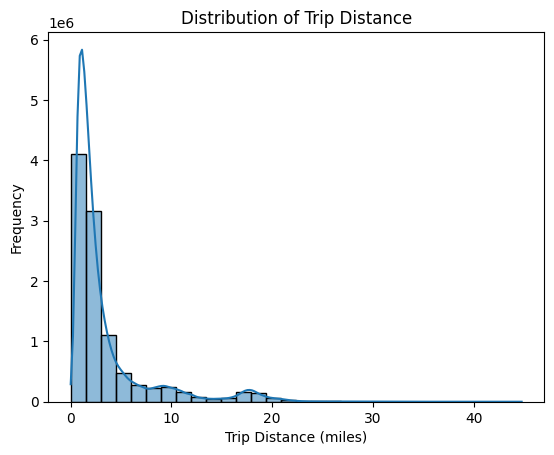

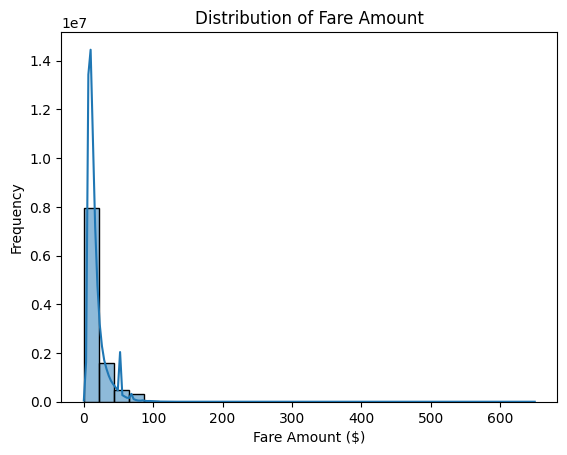

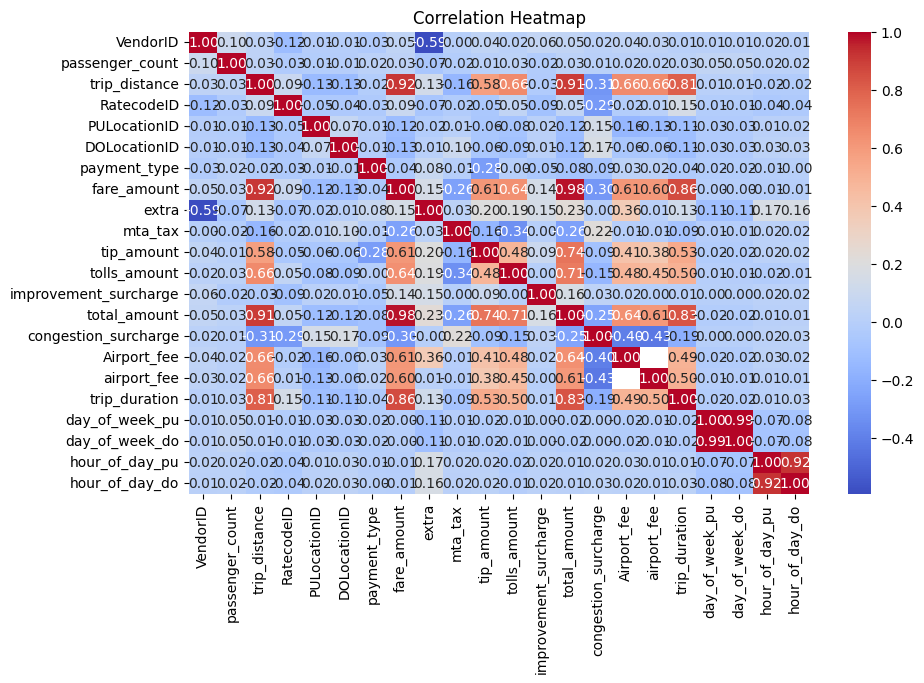

In [16]:

# Load the preprocessed data
processed_data_path = "/content/drive/MyDrive/yellow_processed_05.parquet"
cleaned_df = pd.read_parquet(processed_data_path)

# Visualize the data
# Distribution of trip distance
sns.histplot(cleaned_df['trip_distance'], kde=True, bins=30)
plt.title("Distribution of Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

# Distribution of fare amount
if 'fare_amount' in cleaned_df.columns:
    sns.histplot(cleaned_df['fare_amount'], kde=True, bins=30)
    plt.title("Distribution of Fare Amount")
    plt.xlabel("Fare Amount ($)")
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap
numeric_df = cleaned_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



In [18]:
cleaned_df['fare_amount'].describe()

,fare_amount
count,1.036978e+07
mean,1.789875e+01
std,1.510588e+01
min,1.000000e-02
25%,8.600000e+00
50%,1.280000e+01
75%,2.050000e+01
max,6.500000e+02


<Axes: xlabel='trip_distance', ylabel='fare_amount'>

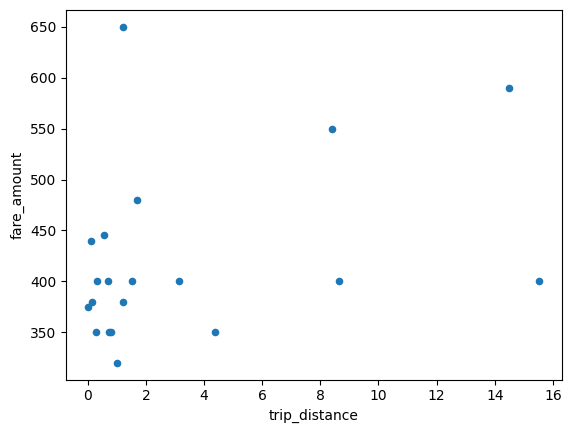

In [19]:
three_std_deviations = 1.465398e+01 + 3 * 9.641945e+01
mask_above_three_std_deviations = cleaned_df['fare_amount'] > three_std_deviations
below_crazy_fare_amount = cleaned_df['fare_amount'] < 50000

cleaned_df[mask_above_three_std_deviations & below_crazy_fare_amount].plot.scatter(x='trip_distance', y='fare_amount')

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

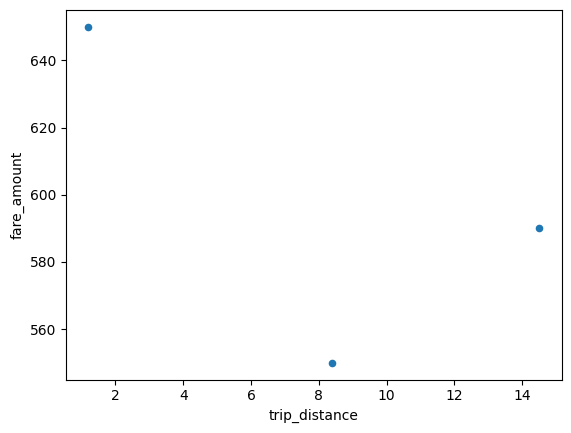

In [20]:
mask_fares_below_7000 = cleaned_df['fare_amount'] < 6000
mask_fares_above_6000 = cleaned_df['fare_amount'] > 500
mask_initiated_outside_nyc = cleaned_df['PULocationID'] == 265
mask_dropped_outside_nyc = cleaned_df['DOLocationID'] == 265
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000].plot.scatter(x='trip_distance', y='fare_amount')


In [21]:
cleaned_df[mask_fares_above_6000 & mask_fares_below_7000][['Borough_pu', 'Borough_do', 'DOLocationID', 'trip_distance', 'fare_amount']].head()

,Borough_pu,Borough_do,DOLocationID,trip_distance,fare_amount
2231078,Manhattan,Manhattan,162,1.2,650.00
4966954,Manhattan,Queens,129,8.4,550.00
5808103,Queens,Queens,7,14.5,590.01


In [22]:
cleaned_df.size - cleaned_df[cleaned_df['PULocationID'] == 265].size


342202707

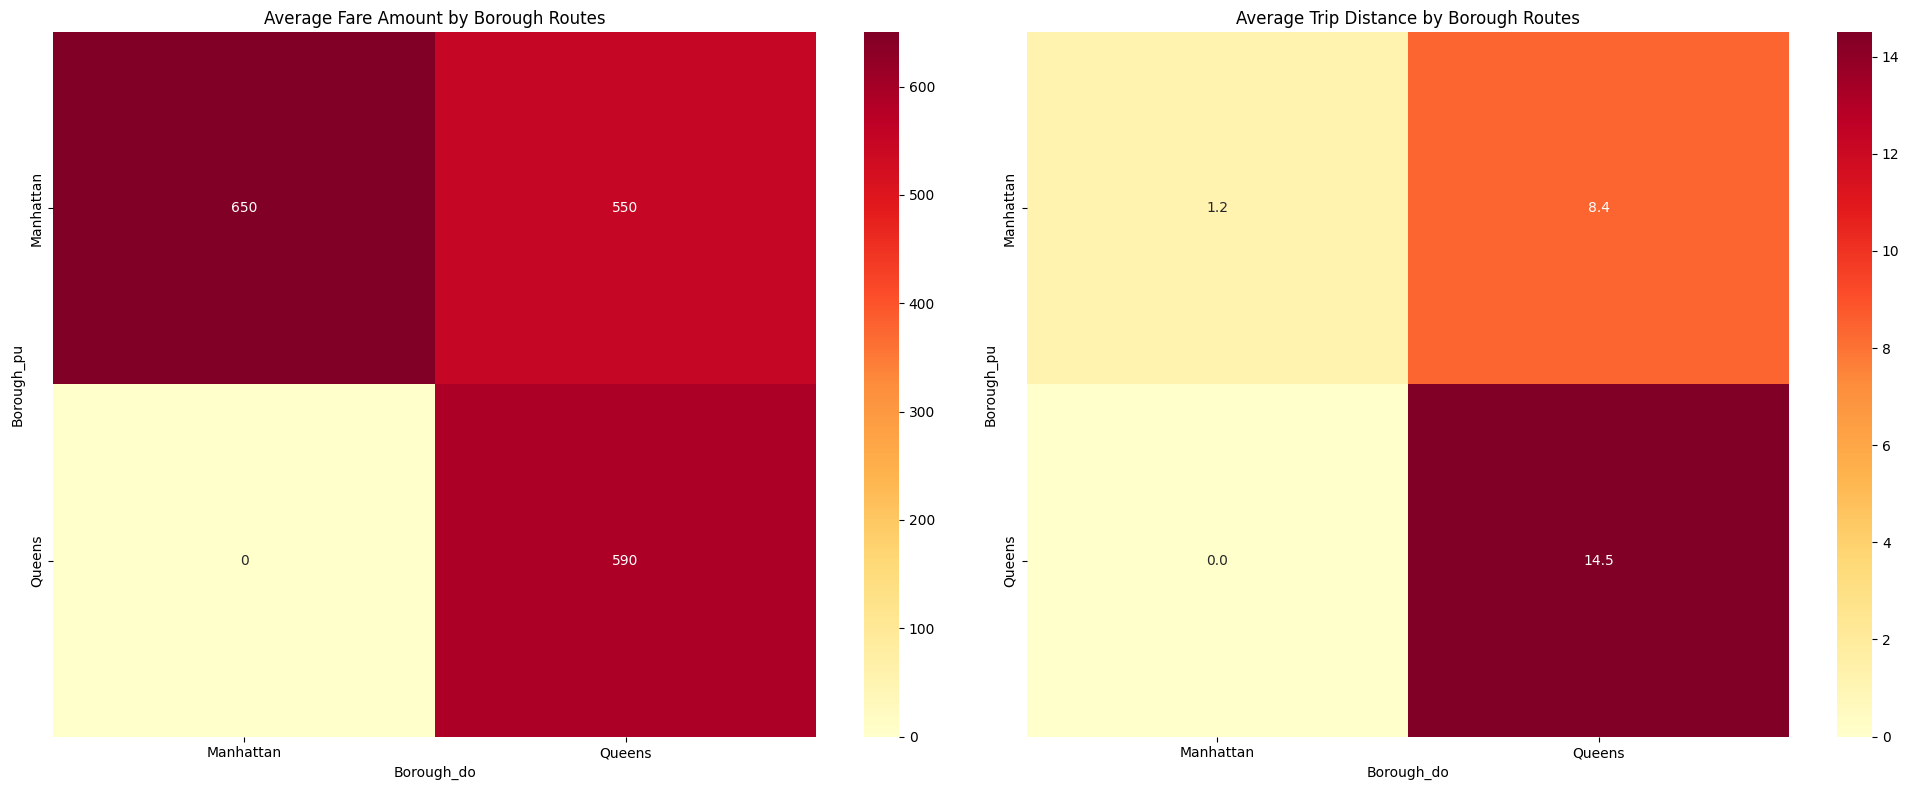


Summary of trips between boroughs:
  Pickup Borough Dropoff Borough  Number of Trips
0      Manhattan       Manhattan                1
1      Manhattan          Queens                1
2         Queens          Queens                1


In [23]:
filtered_df = cleaned_df[mask_fares_above_6000 & mask_fares_below_7000]
analyze_borough_trips(filtered_df)

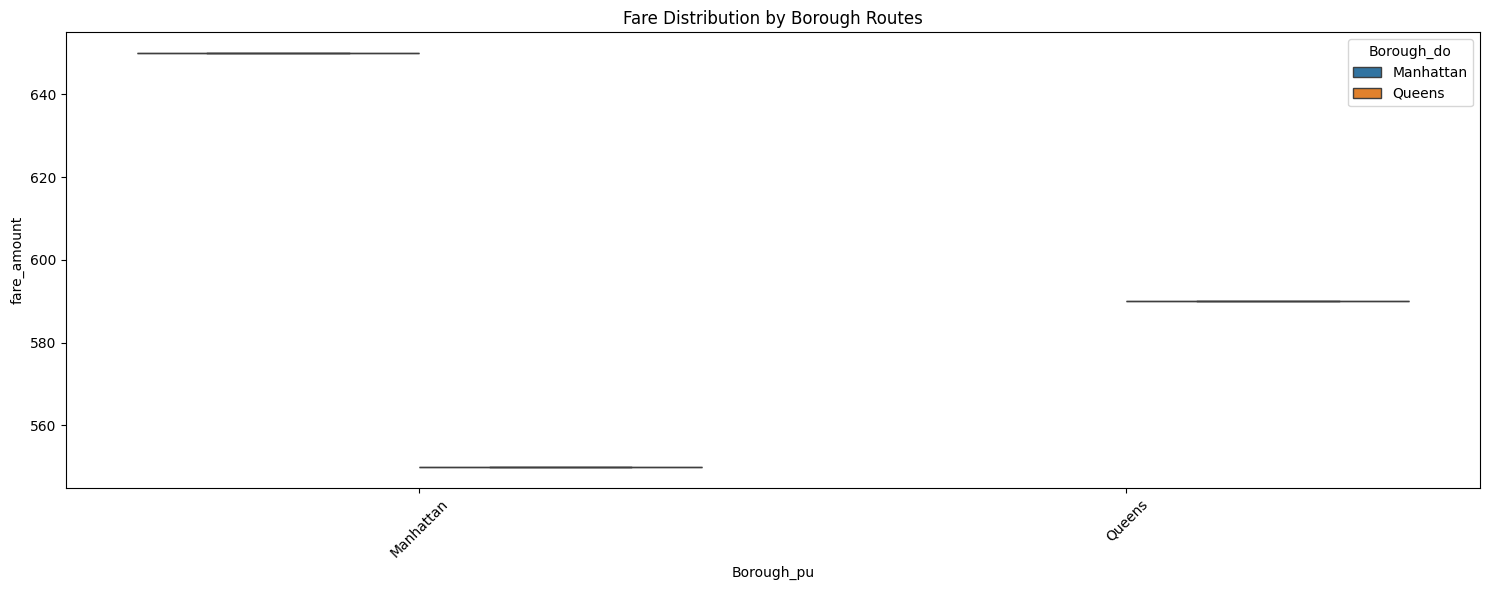

In [24]:
plot_fare_distributions(filtered_df)

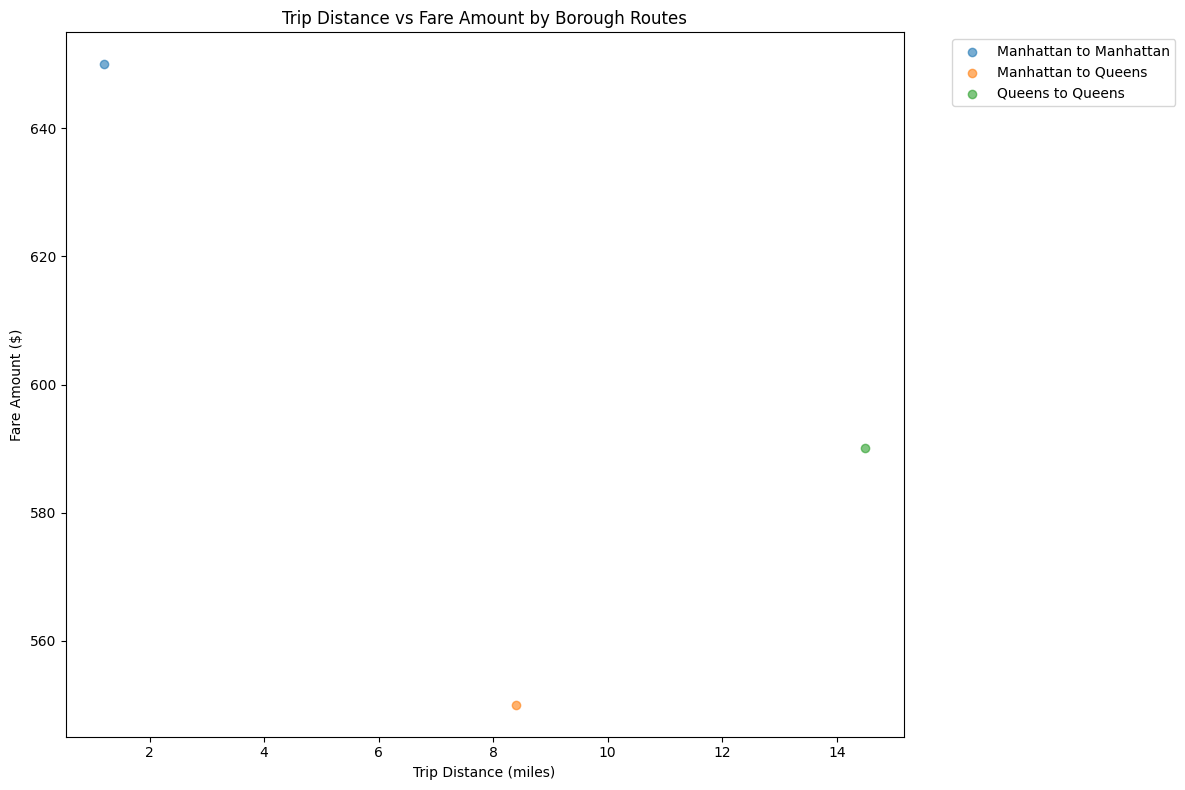

In [25]:
plot_distance_vs_fare(filtered_df)

In [26]:
short_trips = cleaned_df[cleaned_df['trip_distance'] <= 0.01]
short_trips_not_in_same_zone = short_trips[short_trips['PULocationID'] != short_trips['DOLocationID']]
short_trips_not_same_borough = short_trips_not_in_same_zone[short_trips_not_in_same_zone['Borough_do_zone'] != short_trips_not_in_same_zone['borough']]

short_trips_not_in_same_zone[['PULocationID', 'DOLocationID']].value_counts()

KeyError: 'Borough_do_zone'

In [27]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'airport_fee',
       'trip_duration', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'day_of_week_do', 'hour_of_day_pu', 'hour_of_day_do', 'time_of_day_pu',
       'time_of_day_do'],
      dtype='object')

In [ ]:
cleaned_df['Borough_do_zone'].value_counts()

Borough_do_zone
Manhattan        34672346
Queens            2109647
Brooklyn          1524470
Bronx              233924
Unknown            228124
EWR                106257
Staten Island        9666
Name: count, dtype: int64

# TRAIN THE MODEL

# we need to create a model using tensorflow to best predict the data, we'll use the cleaned_df for it

In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
cleaned_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'airport_fee',
       'trip_duration', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'day_of_week_do', 'hour_of_day_pu', 'hour_of_day_do', 'time_of_day_pu',
       'time_of_day_do'],
      dtype='object')

In [9]:
target = ['trip_duration', 'fare_amount']
features = ['trip_distance', 'store_and_fwd_flag', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'day_of_week_pu',
       'day_of_week_do', 'hour_of_day_pu', 'hour_of_day_do', 'time_of_day_pu',
       'time_of_day_do']

In [10]:
X = cleaned_df[features]
y = cleaned_df[target]

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Preprocessing pipeline
categorical_features = ['store_and_fwd_flag', 'Borough_pu', 'Zone_pu', 'service_zone_pu',
       'Borough_do', 'Zone_do', 'service_zone_do', 'time_of_day_pu',
       'time_of_day_do']
numerical_features = ['trip_distance', 'day_of_week_pu',
       'day_of_week_do', 'hour_of_day_pu', 'hour_of_day_do']

In [13]:
# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [15]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [16]:
y_train = y_train.values
y_test = y_test.values

In [17]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['mae'])

In [32]:
checkpoint_cb = ModelCheckpoint(
    filepath='best_regression_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [33]:
history = model.fit(X_train, y_train[:, 0],
                    validation_split=0.2,
                    epochs=20,
                    batch_size=64,
                    callbacks=[checkpoint_cb])

Epoch 1/20
103698/103698 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.8834 - mae: 3.5663
Epoch 1: val_loss improved from inf to 31.47294, saving model to best_regression_model.keras
103698/103698 ━━━━━━━━━━━━━━━━━━━━ 286s 3ms/step - loss: 31.8834 - mae: 3.5663 - val_loss: 31.4729 - val_mae: 3.5602
Epoch 2/20
103673/103698 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4893 - mae: 3.5589
Epoch 2: val_loss did not improve from 31.47294
103698/103698 ━━━━━━━━━━━━━━━━━━━━ 286s 3ms/step - loss: 31.4894 - mae: 3.5589 - val_loss: 31.4879 - val_mae: 3.6020
Epoch 3/20
103696/103698 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.5284 - mae: 3.5624
Epoch 3: val_loss did not improve from 31.47294
103698/103698 ━━━━━━━━━━━━━━━━━━━━ 292s 3ms/step - loss: 31.5284 - mae: 3.5624 - val_loss: 31.5316 - val_mae: 3.5613
Epoch 4/20
103695/103698 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.7858 - mae: 3.5645
Epoch 4: val_loss improved from 31.47294 to 31.47006, saving model to best_regression_model.keras
103698/103

In [34]:
type(history)

keras.src.callbacks.history.History

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test[:,0], y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test[:,0], y_pred)
r2 = r2_score(y_test[:,0], y_pred)

print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R^2:  {r2:.2f}")

64812/64812 ━━━━━━━━━━━━━━━━━━━━ 159s 2ms/step
MSE:  32.12
RMSE: 5.67
MAE:  3.63
R^2:  0.86


In [47]:
y

,fare_amount,trip_duration
0,28.20,24.583333
1,46.40,31.266667
2,35.90,16.966667
3,30.30,24.066667
4,61.80,40.833333
...,...,...
10369774,10.88,8.166667
10369775,11.68,14.466667
10369776,14.54,21.000000
10369777,24.01,26.016667
